# Wildfires localization (Alaska 2004 - 2005)
## A proof of concept on a small area (WIP)
---------------------------------

*Add description of project*

Add the root directory of this project to the Python paths. The mlfire package is located there.

In [1]:
import sys
sys.path.append('..')

Import a functionality for lazy importing packages. The packages will be loaded using a lazy importing approach then.

In [2]:
from mlfire.utils.functool import lazy_import

## Get file names (satellite images and labels)

In [3]:
ee_collections = lazy_import('mlfire.earthengine.collections')
os = lazy_import('os')

A prefix of sources (satellite images and labels) and a location where images (GeoTIFFs) are placed.

In [4]:
DATA_DIR = '../data/tifs'
PREFIX_IMG = 'ak_reflec_january_december_{}_100km'

We use the MTBS labelling for wildfires in this example. See the Google Earth Engine catalog on https://developers.google.com/earth-engine/datasets/catalog/USFS_GTAC_MTBS_annual_burn_severity_mosaics_v1 for futher details.

In [5]:
LABEL_COLLECTION = ee_collections.FireLabelsCollection.MTBS
STR_LABEL_COLLECTION = LABEL_COLLECTION.name.lower()

Get filenames of satellite images and labels and store them to lists.

In [6]:
lst_satimgs = []
lst_labels = []

for year in range(2004, 2006):

    PREFIX_IMG_YEAR = PREFIX_IMG.format(year)

    fn_satimg = '{}_epsg3338_area_0.tif'.format(PREFIX_IMG_YEAR)
    fn_satimg = os.path.join(DATA_DIR, fn_satimg)
    lst_satimgs.append(os.path.abspath(fn_satimg))

    fn_labels = '{}_epsg3338_area_0_{}_labels.tif'.format(PREFIX_IMG_YEAR, STR_LABEL_COLLECTION)
    fn_labels = os.path.join(DATA_DIR, fn_labels)
    lst_labels.append(os.path.abspath(fn_labels))

List of satellite images.

In [7]:
print(lst_satimgs)

['/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2004_100km_epsg3338_area_0.tif', '/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2005_100km_epsg3338_area_0.tif']


List of labels.

In [8]:
print(lst_labels)

['/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2004_100km_epsg3338_area_0_mtbs_labels.tif', '/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2005_100km_epsg3338_area_0_mtbs_labels.tif']


## Data adapter settings

In [9]:
data_ts = lazy_import('mlfire.data.ts')
features_pca = lazy_import('mlfire.features.pca')

**TODO add a comment**

In [10]:
DatasetTransformOP = data_ts.DatasetTransformOP
FactorOP = features_pca.FactorOP

TRANSFORM_OPS = [DatasetTransformOP.STANDARTIZE_ZSCORE, DatasetTransformOP.PCA]
PCA_OPS = [FactorOP.TEST_CUMSUM]

**TODO add a comment**

In [11]:
DatasetSplitOpt = data_ts.DatasetSplitOpt
DS_SPLIT_OPT = DatasetSplitOpt.IMG_HORIZONTAL_SPLIT

**TODO add a comment**

In [12]:
TEST_RATIO = 1. / 3.

**TODO add a comment**

In [13]:
adapter_ts = data_ts.DataAdapterTS(
    lst_satimgs=lst_satimgs,
    lst_labels=lst_labels,
    label_collection=LABEL_COLLECTION,
    mtbs_severity_from=ee_collections.MTBSSeverity.LOW,
    # transformation options
    transform_ops=TRANSFORM_OPS,
    pca_ops=PCA_OPS,
    # data set split options
    ds_split_opt=DS_SPLIT_OPT,
    test_ratio=TEST_RATIO,
)

## Dates

In [53]:
adapter_ts.satimg_dates

,Date,Image ID
0,2004-01-01,0
1,2004-01-09,0
2,2004-01-17,0
3,2004-01-25,0
4,2004-02-02,0
...,...,...
87,2005-11-25,1
88,2005-12-03,1
89,2005-12-11,1
90,2005-12-19,1


In [55]:
adapter_ts.label_dates

,Date,Image ID
0,2004-01-01,0
1,2005-01-01,1


### Satellite image

In [16]:
data_view = lazy_import('mlfire.data.view')

In [63]:
SatImgViewOpt = data_view.SatImgViewOpt
lst_view_opt = [SatImgViewOpt.NATURAL_COLOR, SatImgViewOpt.SHORTWAVE_INFRARED2, 
                SatImgViewOpt.CIR, SatImgViewOpt.NDVI]

In [64]:
IMG_ID = 70
adapter_ts.ndvi_view_threshold = .5

In [65]:
itertools = lazy_import('itertools')
plt = lazy_import('matplotlib.pylab')
utils_plt = lazy_import('mlfire.utils.plots')

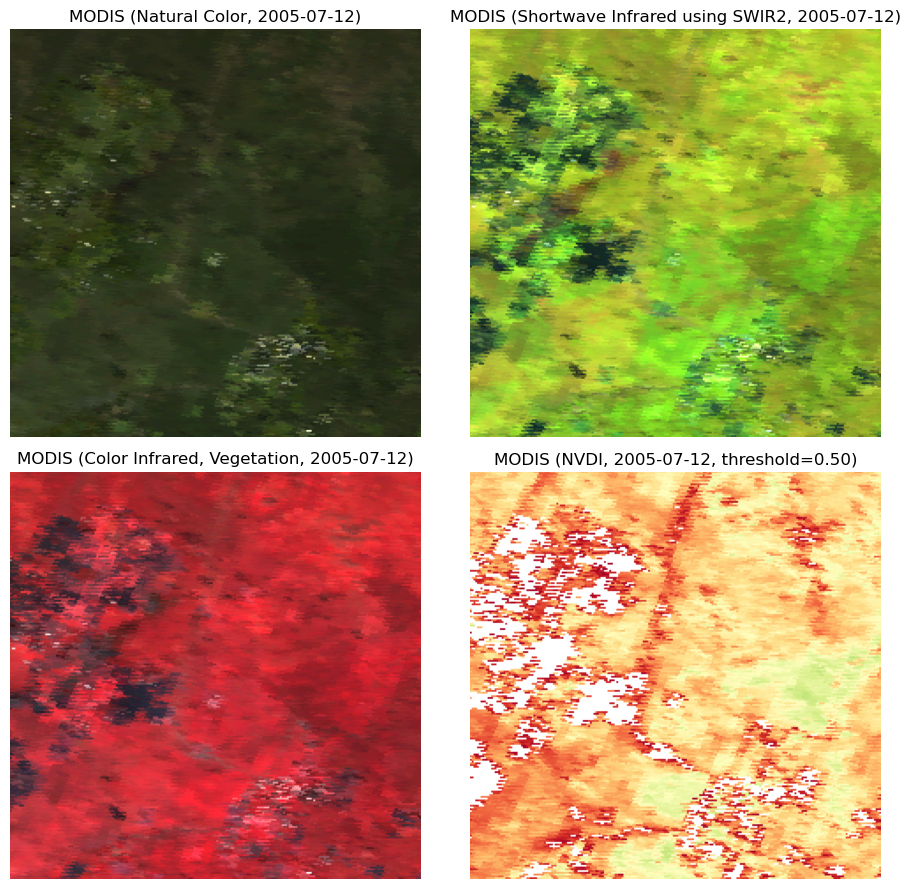

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))

for i, j in itertools.product(*[range(2)] * 2):
        
    adapter_ts.satimg_view_opt = lst_view_opt[i * 2 + j]
    adapter_ts.showSatImage(IMG_ID, ax=axes[i][j], show=False)

### Fire Labels (MTBS)

In [41]:
WITH_UNCHARTED_AREAS=True

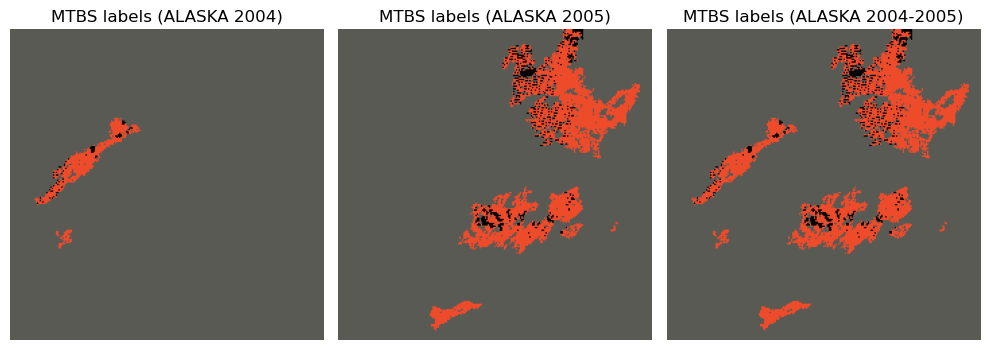

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(10, 12))

adapter_ts.showFireLabels(
    id_bands=0, figsize=(3.5, 3.5), show_uncharted_areas=WITH_UNCHARTED_AREAS, show=False, ax=axes[0]
)
adapter_ts.showFireLabels(
    id_bands=1, figsize=(3.5, 3.5), show_uncharted_areas=WITH_UNCHARTED_AREAS, show=False, ax=axes[1]
)
adapter_ts.showFireLabels(
    id_bands=range(0, 2), figsize=(3.5, 3.5), show_uncharted_areas=WITH_UNCHARTED_AREAS, show=False, ax=axes[2]
)

In [46]:
BRIGHTNESS_FACTORS=(7, 7)

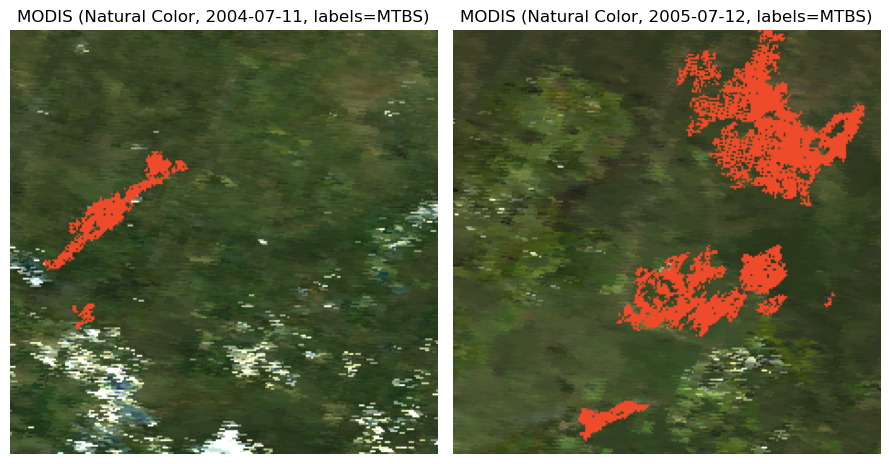

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))

adapter_ts.satimg_view_opt = SatImgViewOpt.NATURAL_COLOR
adapter_ts.showSatImageWithFireLabels(
    id_img=24, brightness_factors=BRIGHTNESS_FACTORS, figsize=(3.5, 3.5), show=False, ax=axes[0]
)
adapter_ts.showSatImageWithFireLabels(
    id_img=70, brightness_factors=BRIGHTNESS_FACTORS,figsize=(3.5, 3.5), show=False, ax=axes[1]
)

## Creating data sets

In [25]:
id_start_date = 0
adapter_ts.ds_start_date = adapter_ts.satimg_dates.iloc[id_start_date]['Date']
print('Data set start date {}'.format(adapter_ts.satimg_dates.iloc[id_start_date]['Date']))

Data set start date 2004-01-01


In [26]:
id_start_date = -1
print('Data set end date {}'.format(adapter_ts.satimg_dates.iloc[id_start_date]['Date']))
adapter_ts.ds_end_date = adapter_ts.satimg_dates.iloc[id_start_date]['Date']

Data set end date 2005-12-27


In [27]:
adapter_ts.createDataset()

ds_train = adapter_ts.getTrainingDataset()
ds_test = adapter_ts.getTestDataset()

PCA cumsum test, found explainable 60 latent factors
PCA cumsum test, found explainable 71 latent factors
PCA cumsum test, found explainable 56 latent factors
PCA cumsum test, found explainable 59 latent factors
PCA cumsum test, found explainable 73 latent factors
PCA cumsum test, found explainable 72 latent factors
PCA cumsum test, found explainable 71 latent factors


In [28]:
ts_train = ds_train[0]; label_train = ds_train[1]
ts_test = ds_test[0]; label_test = ds_test[1]

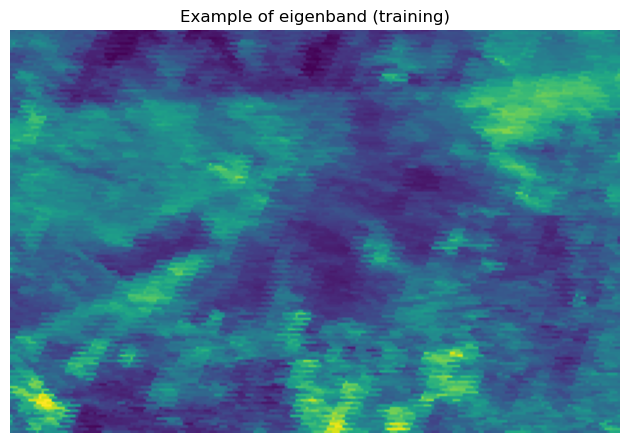

In [29]:
utils_plt.imshow(ts_train[10], title='Example of eigenband (training)', show=True)

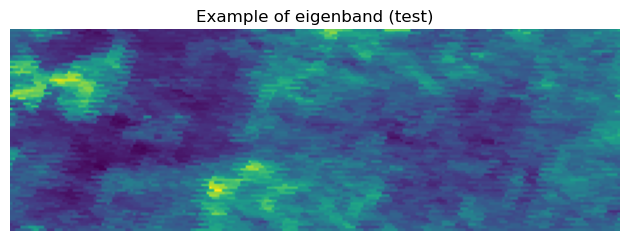

In [30]:
utils_plt.imshow(ts_test[10], title='Example of eigenband (test)', show=True)

### Training model

In [31]:
np = lazy_import('numpy')
xgboost = lazy_import('xgboost')

imblearn_metrics = lazy_import('imblearn.metrics')
sklearn_metrics = lazy_import('sklearn.metrics')

XGBClassifier = xgboost.XGBClassifier
classification_report_imbalanced = imblearn_metrics.classification_report_imbalanced
classification_report = sklearn_metrics.classification_report

In [32]:
tmp_shape_train = ts_train.shape
tmp_ts_train = ts_train.reshape(tmp_shape_train[0], -1).T

tmp_shape_test = ts_test.shape
tmp_ts_test = ts_test.reshape(tmp_shape_test[0], -1).T

In [33]:
label_train = label_train.reshape(-1)
label_test = label_test.reshape(-1)

Remove nan values

In [34]:
ts_train_nona = tmp_ts_train[~np.isnan(label_train)]
label_train_nona = label_train[~np.isnan(label_train)]

ts_test_nona = tmp_ts_test[~np.isnan(label_test)]
label_test_nona = label_test[~np.isnan(label_test)]

Train XGBoost classifier (without hyper parameter optimization)

In [35]:
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(ts_train_nona, label_train_nona)

KeyboardInterrupt: 

### Train data set

In [ ]:
labels_pred = xgb.predict(ts_train_nona)

In [ ]:
print('\n Report\n')
print(classification_report(label_train_nona, labels_pred))
print('\n Report (imbalanced)\n')
print(classification_report_imbalanced(label_train_nona, labels_pred))

In [ ]:
output = np.empty(shape=label_train.shape, dtype=label_train.dtype); output[:] = np.nan
output[~np.isnan(label_train)] = labels_pred

In [ ]:
utils_plt.imshow(label_train.reshape(tmp_shape_train[1:3]), title='Ground truth (train)')

In [ ]:
utils_plt.imshow(output.reshape(tmp_shape_train[1:3]), title='Predicted (train)')

### Test data set

In [ ]:
labels_pred = xgb.predict(ts_test_nona)

In [ ]:
print('\n Report\n')
print(classification_report(label_test_nona, labels_pred))
print('\n Report (imbalanced)\n')
print(classification_report_imbalanced(label_test_nona, labels_pred))

In [ ]:
output = np.empty(shape=label_test.shape, dtype=label_test.dtype); output[:] = np.nan
output[~np.isnan(label_test)] = labels_pred

In [ ]:
utils_plt.imshow(label_test.reshape(tmp_shape_test[1:3]), title='Ground truth (test)')

In [ ]:
utils_plt.imshow(output.reshape(tmp_shape_test[1:3]), title='Predicted (test)')